# indexed RT alignment

In [1]:
from importlib import reload
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
maxquant_file =  '/mnt/cmnfs/proj/ORIGINS/data/protMSD/GCF_profile/combined/txt/evidence_peprec_input.txt' # path to MaxQuant results (evidence.txt) of the same RAW file, used for constructing reference dictionary
maxquant_msms = '/mnt/cmnfs/proj/ORIGINS/data/protMSD/GCF_profile/combined/txt/msms.txt'
msconvert_file = '/mnt/cmnfs/proj/ORIGINS/data/protMSD/GCF_profile/msconvert_profile.mzML' # path to the data input in mzML format, containing only MS1 level data
Maxquant_result = pd.read_csv(filepath_or_buffer=maxquant_file, sep='\t')
Maxquant_msms = pd.read_csv(filepath_or_buffer=maxquant_msms, sep='\t')


## From mod seq to RT prediction

In [4]:
# Convert msms.txt to PEPREC format
from psm_utils.io.maxquant import MSMSReader
from psm_utils.io.peptide_record import to_dataframe
reader = MSMSReader(maxquant_file)
psm_list = reader.read_file()
psm_list.add_fixed_modifications([("Carbamidomethyl", ["C"])])
psm_list.apply_fixed_modifications() 
psm_list.rename_modifications({
    "ox":"Oxidation",
    "ac":"Acetyl"
})
peprec = to_dataframe(psm_list)


In [5]:
peprec_RTpred = peprec.groupby(by = ['peptide', 'modifications'])['observed_retention_time'].median().reset_index()

## RT prediction

### prepare input files

In [6]:
## rename
peprec_RTpred = peprec_RTpred.rename(columns = {'peptide':'seq',
                                                'observed_retention_time':'tr'})
peprec_RTpred = peprec_RTpred[['seq', 'modifications', 'tr']]
peprec_RTpred.to_csv('evidence_RT_transfer.csv', sep=',')
## Randomly sample x percentage of peptide + first and last peptide for calibration
peprec_RTpred_cal = peprec_RTpred.sample(int(np.round(peprec_RTpred.shape[0]*0.5)))

In [7]:
from deeplc import DeepLC
dlc = DeepLC()
dlc.calibrate_preds(seq_df=peprec_RTpred_cal)
preds = dlc.make_preds(seq_df=peprec_RTpred)

9/9 [==============================] - 4s 410ms/step


{}

17/17 [==============================] - 7s 422ms/step


In [8]:
# RT pred evaluation
%matplotlib inline
peprec_RTpred['predicted_RT'] = preds
peprec_RTpred['observed_iRT'] = peprec_RTpred['tr'].rank(method = 'average', ascending=True, na_option='bottom')


### Evaluate RT prediction

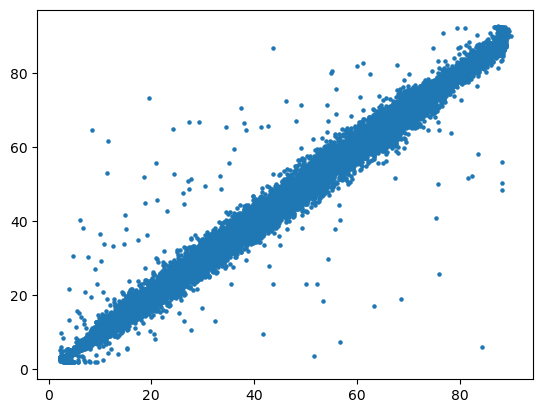

In [10]:
plt.scatter(x = peprec_RTpred['predicted_RT'], y = peprec_RTpred['tr'], s = 5)
plt.show()

<module 'utils.metrics' from '/mnt/cmnfs/proj/ORIGINS/protMSD/maxquant/ScanByScan/utils/metrics.py'>

9.541379557990126

Green line shows deltaRT 95
Data:  tr predicted_RT , slope =  0.983 , intercept =  0.723 , PearsonR =  0.992 , SpearmanR =  0.992


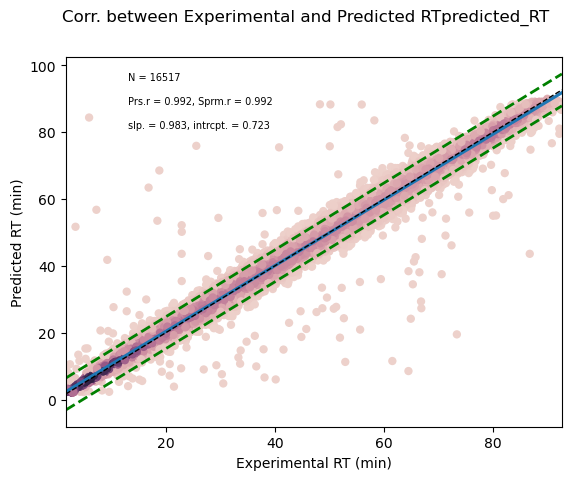

In [12]:
import utils.metrics
reload(utils.metrics)
from utils.metrics import RT_metrics
RTmetric = RT_metrics(RT_obs = peprec_RTpred['tr'], RT_pred = peprec_RTpred['predicted_RT'])
RTmetric.CalcDeltaRTwidth(95)
RTmetric.PlotRTScatter()

In [69]:
peprec_final = pd.merge(left=peprec, right = peprec_RTpred, 
                        left_on=['peptide', 'modifications'], 
                        right_on=['seq', 'modifications'],
                        how = 'inner'
                        )
Maxquant_msms_new = pd.concat([Maxquant_msms, peprec_final[['predicted_RT']]], axis = 1)
Maxquant_msms_new.to_csv(path_or_buf='msms_with_predRT.txt', sep='\t')

### In silico digest result

In [ ]:
forDeepLC = pd.DataFrame({'seq': Maxquant_result['Sequence'], 
                          'modifications': ''
                          })
dlc = DeepLC()
preds = dlc.make_preds(seq_df=forDeepLC, calibrate=False)

43/43 [==============================] - 16s 362ms/step


In [ ]:
Maxquant_result['RT_pred'] = np.round(preds, decimals=2)

NameError: name 'np' is not defined

In [ ]:
unique_mono2_seq = Maxquant_result.groupby(['Peptide_mass_round2', 'RT_pred']).agg({'Sequence':'count'}).reset_index()
unique_mono2_seq.loc[unique_mono2_seq['Sequence'] >1, 'Sequence'].describe()

count    2548.00000
mean        2.02551
std         0.17199
min         2.00000
25%         2.00000
50%         2.00000
75%         2.00000
max         4.00000
Name: Sequence, dtype: float64

## Elution inference

In [64]:
import pickle
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from optimization.dictionary import LoadMZML, get_RT_edge

In [65]:
# Load MS1 scans from pkl or mzml file
try:
    with open(msconvert_file[:-5]+'.pkl', 'rb') as f:
        MS1Scans = pickle.load(f)
    print('Load pre-stored pickle results')
except:
    print('Pickle result not found, load mzml file.')
    MS1Scans = LoadMZML(msconvert_file)
    MS1Scans.to_pickle(msconvert_file[:-5]+'.pkl')
    

Load pre-stored pickle results


In [ ]:
ScanIdx = get_RT_edge()